### Check quality of local drone movement calculation  

Compare difference between locations projected into map from same frame but two different camera matrices. The first camera matrix used for each comparison is the  camera matrix of the last anchor plus the local movement estimation up to the next anchor frame. The second camera matreix used for each comparrison is the actual computed camera matrix for the next camera frame calculated in the structure from motion step. If the local drone movement estimiation was correct the animal positions in a given anchor frame projected through these two matricies should be very close to each other in the 3D map. If it wasn't done well then they could be far appart for certain or all positions in that anchor frame. This distance is a way to estimate the maximum expected possiible projection error introduced by the local drone movement calcualtion step for each set of frames between anchors. 

In [2]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np

# local .json file with local path info
ungulates_root = os.path.dirname(os.getcwd())
local_paths_file = os.path.join(ungulates_root, 'local-paths.json')
with open(local_paths_file, "r") as json_file:
    local_paths = json.load(json_file)

import sys
sys.path.append(local_paths['overhead_functions_path'])

import koger_general_functions as kgf
import mapping_functions as kmap

plt.style.use('dark_background')

In [2]:
# keep as '*' to get all observations, or change to specific observation name 
observation_name = "observation088"
# Name of the track file that should be projected into landscape
tracks_name = "tracks-complete.npy"
# new_style should be True is using file format used througout worked examples
new_style = True
# Name of folder where data extracted in "extract_drone_movement.ipynb" was saved
drone_movement_folder_name = "worked_examples_drone_movement"
# Project name assosiated with the saved pix4d files
pix4d_project_name = "observation088"


map_folder = os.path.join(local_paths['pix4d_folder'], observation_name)

if new_style:
    tracks_file = os.path.join(local_paths['processed_folder'], observation_name, 
                               tracks_name)
else:   
    tracks_file = os.path.join(local_paths['processed_folder'], observation_name, 
                               "localizations", tracks_name)
frame_folders_root = os.path.join(local_paths['base_frames_folder'], observation_name)

drone_movement_folder = os.path.join(frame_folders_root, drone_movement_folder_name)

In [3]:
pix4d_info = kmap.get_pix4d_info(map_folder, pix4d_project_name)

In [4]:
tracks = np.load(tracks_file, allow_pickle=True)

anchor_obs_indexes = kmap.get_anchor_obs_indexes(pix4d_info['pmatrices'], 
                                                 frame_folders_root=frame_folders_root)

segment_movement_files = glob.glob(
    os.path.join(drone_movement_folder,"drone_movement_segment_*.npy"))
segment_movements = [np.load(file) for file in sorted(segment_movement_files)]

segment_inlier_files = glob.glob(
    os.path.join(drone_movement_folder,"inliers_segment_*.npy"))
segment_inliers = [np.load(file) for file in sorted(segment_inlier_files)]

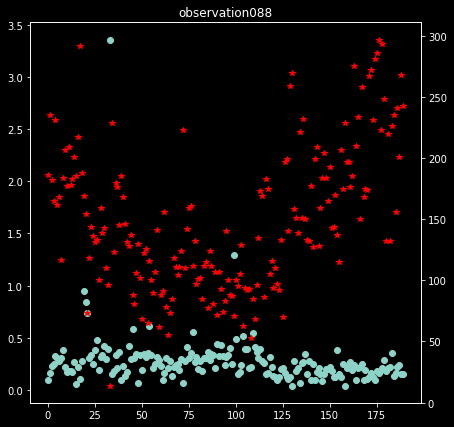

In [5]:
# (meters) consider points on ray within .1 meters of ground to be "on ground"
correct_threshold = 0.5
# max guesses to search for point on ray within correct_threshold of the ground
max_guesses = 50 
# Where to start searching along the ray
mu_est = 80
frame_shape = kmap.get_ungulates_frame_shape(supress_warning=False)

segment_errors = []

for gt_ind, gt_obs_ind in enumerate(anchor_obs_indexes[1:]):
    segment_errors.append(
        kmap.calculate_total_segment_error(tracks, gt_obs_ind, gt_ind, 
                                           pix4d_info, segment_movements,
                                           mu_est, max_guesses, correct_threshold, 
                                           frame_shape, object_height=1
                                          )
    )



distances = [np.linalg.norm(e, axis=1) for e in segment_errors]
max_distances = [np.nanmax(d) for d in distances]

min_inliers = [np.min(i) for i in segment_inliers]

plt.figure(figsize=(7, 7))
plt.plot(max_distances, 'o')
plt.title(observation_name)
plt.xlabel("Anchor frame")
plt.ylabel("Maximum error (meters)")
ax2 = plt.gca().twinx()
ax2.plot(min_inliers, 'r*')
ax2.set_ylabel("Minimum number of inlier features in local movement estimation")

### Visually investigate estimated movement between anchor frame pairs
This can be helpful is certain segments have high error and want to see if this driven by local movement estimation issues

In [10]:
import cv2

In [11]:
frame_files = kgf.get_observation_frame_files(frame_folders_root)

Text(0.5, 1.0, 'Observation index: 30455 - raw')

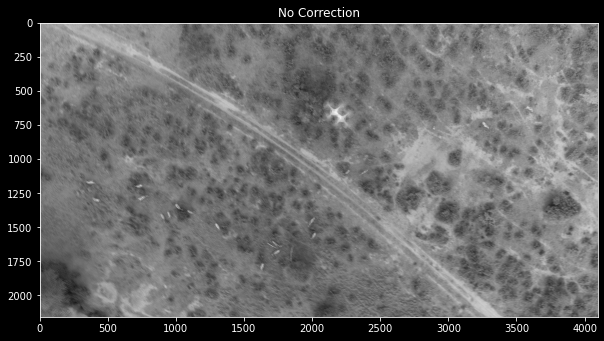

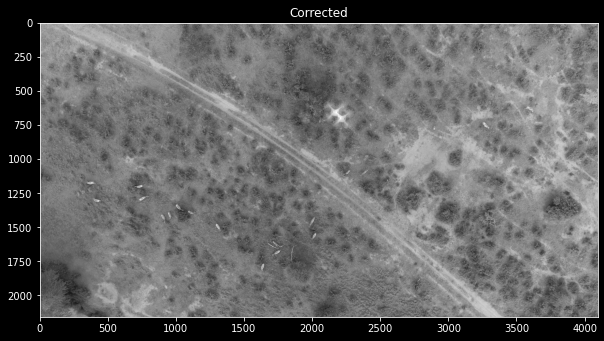

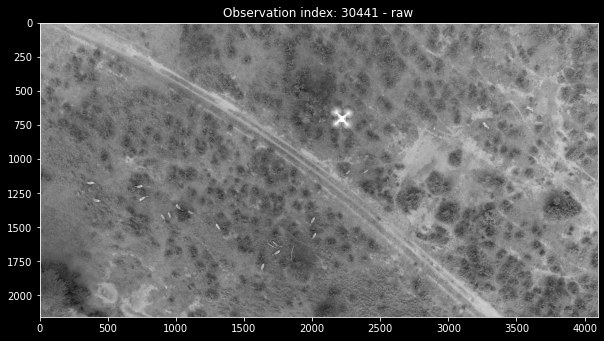

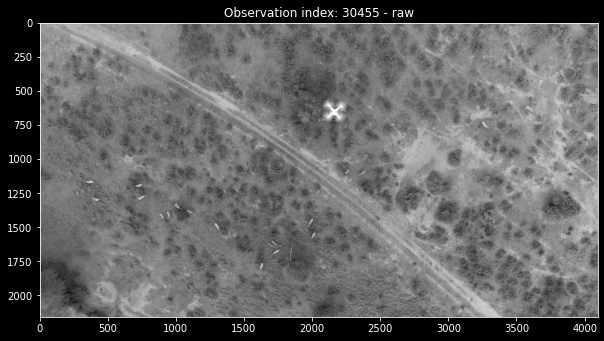

In [26]:
anchor_obs_indexes


anchor_ind = 34

# Anchor frame at beginning of segment
frame0_raw = cv2.imread(frame_files[anchor_obs_indexes[anchor_ind]])
frame0_gray = cv2.cvtColor(frame0_raw, cv2.COLOR_BGR2GRAY)

# Anchor frame at end of segment
frame1_raw = cv2.imread(frame_files[anchor_obs_indexes[anchor_ind+1]])
frame1_gray = cv2.cvtColor(frame1_raw, cv2.COLOR_BGR2GRAY)

# Estimated warp (based on local movement estimation) that should overlay
# anchor 0 onto anchor 1
warp = segment_movements[anchor_ind][-1]

warped_image = cv2.warpAffine(frame1_gray, M=warp[:2], 
                              dsize=(frame0_raw.shape[1], frame0_raw.shape[0]))

plt.figure(figsize=(10, 10))
plt.imshow(frame0_gray, cmap='gray', )
plt.imshow(frame1_gray, alpha=.5, cmap='gray')
plt.title("No Correction")

plt.figure(figsize=(10, 10))
plt.imshow(frame0_gray, cmap='gray', )
plt.imshow(warped_image, alpha=.5, cmap='gray')
plt.title("Corrected")

plt.figure(figsize=(10, 10))
plt.imshow(frame0_gray, cmap='gray')
plt.title(f"Observation index: {anchor_obs_indexes[anchor_ind]} - raw")
plt.figure(figsize=(10, 10))
plt.imshow(frame1_gray, alpha=1.0, cmap='gray')
plt.title(f"Observation index: {anchor_obs_indexes[anchor_ind+1]} - raw")